# AnomalyToolKit: Production check - Real-time mode application

This text explains how to use the productivity checks in the AnomalyToolKit for real-time use.

# Loading modules

Loading the modules we need throughout the notebook and fine-tuning the browser display:

In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1500px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
import numpy 
import pandas
import os
import sys
import time
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append('..')

# Loading data

As an example, we use data from a sensor ageing data repository.  (v1.0.2) [[Zenodo]](https://doi.org/10.5281/zenodo.3229195). Make sure you have downloaded the file `potential_rowB.zip`, unzip the contents into a folder of your liking. Then, make sure the folder path in the following cell matches the folder you have chosen:

In [3]:
strFolder = 'C:/G/data/sensorageing/potential_rowB/'

To enable use of the productivity check, we load all data in a string format. This avoids automatic conversions which may mask some issues with the data.

In [4]:
filename  = Path(strFolder+'rowB_potential_day332.csv')
dfStrData = pandas.read_csv(filepath_or_buffer=filename,delimiter  =';',header =0,dtype=str)
dfStrData.head()

date_time         T1b         T2b         T3b         T4b  \
0  2017.08.31 00:00:01   30.400000    2.700000   -9.300000   48.599998   
1  2017.08.31 00:00:02   30.300001    2.700000   -9.300000   48.599998   
2  2017.08.31 00:00:03   30.400000    2.600000   -9.400000   48.599998   
3  2017.08.31 00:00:04   30.400000    2.700000   -9.400000   48.599998   
4  2017.08.31 00:00:05   30.300001    2.700000   -9.300000   48.599998   

  Unnamed: 5  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

# DateTimeCheck: Setup and testing

We set up an one instance of the class *datetimecheck* in the *production* module and call it *CheckDT*. We define it so that the expected datetime format matches the *date_time* variable in the first 5 lines shown above: 

In [5]:
from basic.production import datetimecheck
CheckDT = datetimecheck(DateTimeFormat='%Y.%m.%d %H:%M:%S')

Now test *CheckDT* on the first data point in the data frame and print the two outputs, which are the result of the check and the datetime string converted to a numpy datetime64 object. Note a single entry must be passed on a list (use of outer square brackets: `DateTimeEntry=[dt1]`)

In [6]:
dt1 = dfStrData['date_time'][0]
xCheckDT , dtSample =CheckDT(DateTimeEntry=[dt1])
print('Result of check: '+str(xCheckDT))
print(dtSample)

Result of check: [True]
[numpy.datetime64('2017-08-31T00:00:01.000000')]


To check if a wrong string format will succesfully be identified, we can just give a random string or emulate that someone changed the datetime format on the data recording device:

In [7]:
dt1 = '2019.23.11 11:11:11'
xCheckDT , dtTime =CheckDT(DateTimeEntry=[dt1])
print('Result of check: '+str(xCheckDT))

Result of check: [False]


The result of the check is now false, as expected (months and days were reversed). The converted datetime object is now 'NaT', which stands for *Not a Time*.

# NumericCheck: Setup and testing

We now set up a check to test if the sensor readings can be interpreted as numeric values. The checks are instances of the class *numericcheck* in the same module (*production*).

In [8]:
from basic.production import numericcheck
CheckNUM = numericcheck(NumberFormat='float')

Now test *CheckNUM* on the first data sensor reading of sensor T4b in the data frame and print the two outputs, which are the result of the check and the string converted to a float object 

In [9]:
xCheckNUM , rValue =CheckNUM(NumberEntry=[dfStrData['T4b'][0]])
print('Result of check: '+str(xCheckNUM))
print(rValue)

Result of check: [True]
[48.599998]


To check if a wrong string format will succesfully be identified, we can just give a random string or emulate that the device printed some special code, like 'N/A'. Such codes could signify power loss, communication loss, an out-of-range sensor reading, ...:

In [10]:
xCheckNUM , rValue =CheckNUM(NumberEntry=['N/A'])
print('Result of check: '+str(xCheckNUM))
print(rValue)

Result of check: [False]
[nan]


The result of the check is now false, as expected (months and days were reversed). The converted datetime object is now 'nan', which stands for *Not a Number*.

# Emulating an online application

Obviously, the data used in this demo is historical data. To emulate an online application, we will use a for loop which runs over all the data points from first to last. The for loop below checks every datetime and every sensor reading in a sequential manner, as one would expect in an online application. The code snippet that would be used in a real-time case is indicated in the comments. The boolean checks are recorded in a separated dataframe together with the produced timestamp.

In [11]:
import numpy as np

x = np.empty((0,), dtype=[('DateTime', np.datetime64),\
                                        ('CheckDateTime',np.bool_),\
                                        ('CheckT1b',np.bool_),\
                                        ('CheckT2b',np.bool_),\
                                        ('CheckT3b',np.bool_),\
                                        ('CheckT4b',np.bool_)])
dfCheck = pandas.DataFrame(x)

NumberOfSamples = len(dfStrData)
#NumberOfSamples =10000

for iSample in range(NumberOfSamples):
    if np.mod(iSample,1000)==0:
        print('Sample '+str(iSample)+' of '+str(NumberOfSamples))
        
    strDateTime = dfStrData['date_time'][iSample]
    strT1a      = dfStrData['T1b'][iSample]
    strT2a      = dfStrData['T2b'][iSample]
    strT3a      = dfStrData['T3b'][iSample]
    strT4a      = dfStrData['T4b'][iSample]
    
    ###########################################################
    ### ADAPT THE CODE BELOW FOR YOUR REAL-TIME APPLICATION ###
    ###########################################################
    
    CheckResult0 , DateTime = CheckDT(DateTimeEntry=[strDateTime])
    CheckResult1 , Number   = CheckNUM(NumberEntry=[strT1a])
    CheckResult2 , Number   = CheckNUM(NumberEntry=[strT2a])
    CheckResult3 , Number   = CheckNUM(NumberEntry=[strT3a])
    CheckResult4 , Number   = CheckNUM(NumberEntry=[strT4a])
    
    ###########################################################
    ###########################################################
    dfCheck = dfCheck.append({'DateTime': DateTime[0],\
                              'CheckDateTime': CheckResult0[0],\
                              'CheckT1b': CheckResult1[0],\
                              'CheckT2b': CheckResult2[0],\
                              'CheckT3b': CheckResult3[0],\
                              'CheckT4b': CheckResult4[0]},ignore_index=True)
    

Sample 0 of 81484
Sample 1000 of 81484
Sample 2000 of 81484
Sample 3000 of 81484
Sample 4000 of 81484
Sample 5000 of 81484
Sample 6000 of 81484
Sample 7000 of 81484
Sample 8000 of 81484
Sample 9000 of 81484
Sample 10000 of 81484
Sample 11000 of 81484
Sample 12000 of 81484
Sample 13000 of 81484
Sample 14000 of 81484
Sample 15000 of 81484
Sample 16000 of 81484
Sample 17000 of 81484
Sample 18000 of 81484
Sample 19000 of 81484
Sample 20000 of 81484
Sample 21000 of 81484
Sample 22000 of 81484
Sample 23000 of 81484
Sample 24000 of 81484
Sample 25000 of 81484
Sample 26000 of 81484
Sample 27000 of 81484
Sample 28000 of 81484
Sample 29000 of 81484
Sample 30000 of 81484
Sample 31000 of 81484
Sample 32000 of 81484
Sample 33000 of 81484
Sample 34000 of 81484
Sample 35000 of 81484
Sample 36000 of 81484
Sample 37000 of 81484
Sample 38000 of 81484
Sample 39000 of 81484
Sample 40000 of 81484
Sample 41000 of 81484
Sample 42000 of 81484
Sample 43000 of 81484
Sample 44000 of 81484
Sample 45000 of 81484
S

In [12]:
dfCheck.head()

DateTime  CheckDateTime  CheckT1b  CheckT2b  CheckT3b  CheckT4b
0 2017-08-31 00:00:01           True      True      True      True      True
1 2017-08-31 00:00:02           True      True      True      True      True
2 2017-08-31 00:00:03           True      True      True      True      True
3 2017-08-31 00:00:04           True      True      True      True      True
4 2017-08-31 00:00:05           True      True      True      True      True

# Visualize the results

In the plots below, we shows the boolean values of the five checks that were executed. As it turns out, the plot are pretty boring: every datatime string and every sensor reading string is accepted.

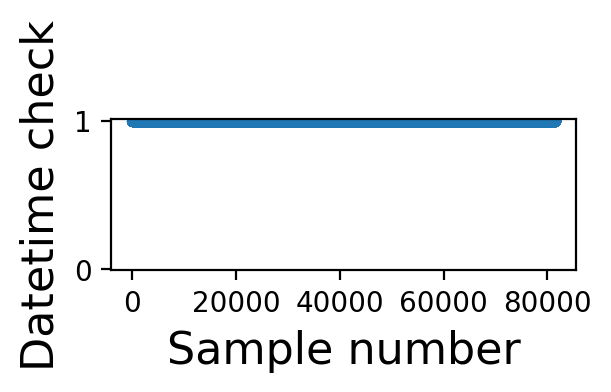

In [13]:
import matplotlib.pyplot as plt

x = np.arange(NumberOfSamples);
y = dfCheck['CheckDateTime'].values;

fig = plt.figure(figsize=(3,1),dpi=200)
plt.plot(y,marker='.',linestyle='none')
ax = fig.gca()
ax.set_xlabel('Sample number', fontsize=16)
ax.set_ylabel('Datetime check', fontsize=16)
ax.set_ylim([-.01,1.01])
ax.set_yticks([0,1]);

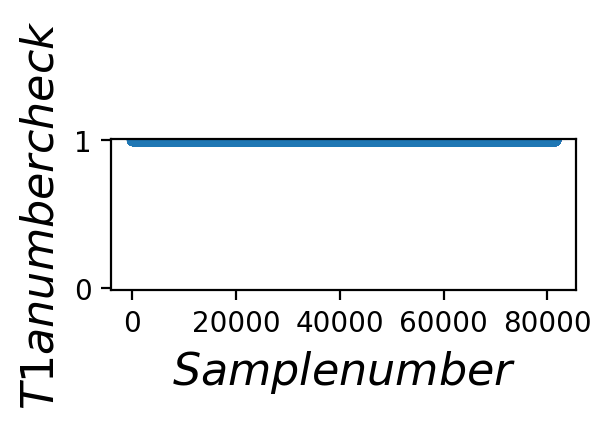

In [14]:
x = np.arange(NumberOfSamples);
y = dfCheck['CheckT1b'];

fig = plt.figure(figsize=(3,1),dpi=200)
plt.plot(y,marker='.',linestyle='none')
ax = fig.gca()
ax.set_xlabel('$Sample number$', fontsize=16)
ax.set_ylabel('$T1a number check$', fontsize=16)
ax.set_ylim([-.01,1.01])
ax.set_yticks([0,1]);

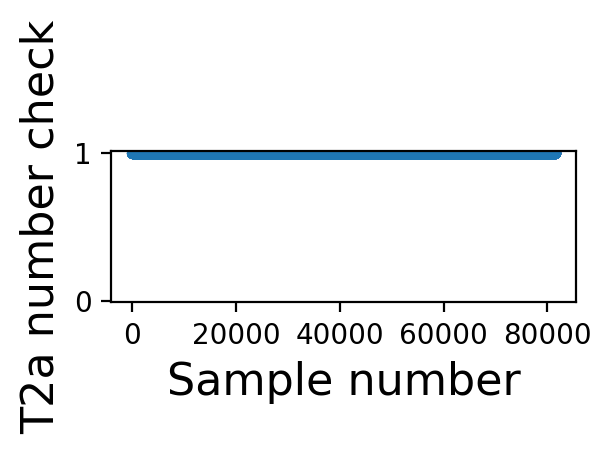

In [15]:
x = np.arange(NumberOfSamples);
y = dfCheck['CheckT2b'];

fig = plt.figure(figsize=(3,1),dpi=200)
plt.plot(y,marker='.',linestyle='none')
ax = fig.gca()
ax.set_xlabel('Sample number', fontsize=16)
ax.set_ylabel('T2a number check', fontsize=16)
ax.set_ylim([-.01,1.01])
ax.set_yticks([0,1]);

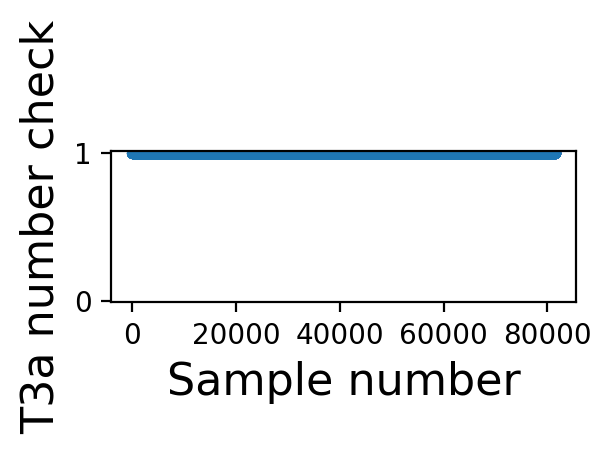

In [16]:
x = np.arange(NumberOfSamples);
y = dfCheck['CheckT3b'];

fig = plt.figure(figsize=(3,1),dpi=200)
plt.plot(y,marker='.',linestyle='none')
ax = fig.gca()
ax.set_xlabel('Sample number', fontsize=16)
ax.set_ylabel('T3a number check', fontsize=16)
ax.set_ylim([-.01,1.01])
ax.set_yticks([0,1]);

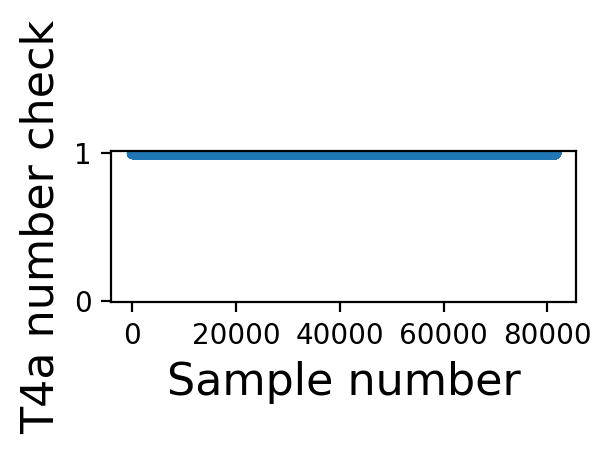

In [17]:
x = np.arange(NumberOfSamples);
y = dfCheck['CheckT4b'];

fig = plt.figure(figsize=(3,1),dpi=200)
plt.plot(y,marker='.',linestyle='none')
ax = fig.gca()
ax.set_xlabel('Sample number', fontsize=16)
ax.set_ylabel('T4a number check', fontsize=16)
ax.set_ylim([-.01,1.01])
ax.set_yticks([0,1]);

# Take home message

This example demonstrates the use of the checks implemented in the *production* module in the AnomalyToolKit software package for the purpose of an online application. We recommend this approach when:

* The validity of the produced data must be checked immediately upon production, e.g. for use in automated application or online model updating

We do not recommend this approach to:

* Check the validity of the produced data some time after the data is produced. In this case, check the notebook `AnomalyToolKit_Demo2_BatchMode_Production.ipynb` and select one of the approaches demonstrated there.